In [1]:
import scanpy as sc
from pathlib import Path
import pandas as pd
import os
import re
import numpy as np
import anndata as ad
from tqdm import tqdm

from jax.config import config

config.update("jax_enable_x64", True)

from joblib import Parallel, delayed
import squidpy as sq
import scanpy as sc
from anndata import AnnData
from scipy.sparse import csr_matrix

%load_ext autoreload
%autoreload 2
%load_ext lab_black

path_read = Path("/lustre/groups/ml01/workspace/giovanni.palla/moscot/processed_data")

2022-08-10 19:00:59.824172: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.2/lib64:/usr/local/cuda/lib64:/usr/local/cuda-11.2/extras/CUPTI/lib64:/usr/local/cuda-11.2/lib64:/usr/local/cuda/lib64:/usr/local/cuda-11.2/extras/CUPTI/lib64
2022-08-10 19:01:03.145467: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.2/lib64:/usr/local/cuda/lib64:/usr/local/cuda-11.2/extras/CUPTI/lib64:/usr/local/cuda-11.2/lib64:/usr/local/cuda/lib64:/usr/local/cuda-11.2/extras/CUPTI/lib64
2022-08-10 19:01:03.957240: W external/org_tensorflow/tensorflow/stream_executor/platform/default/

In [2]:
from pathlib import Path

path_data = "/lustre/groups/ml01/workspace/giovanni.palla/moscot/processed_data"
dataset = 3
split = 2

adata_sc = ad.read(Path(path_data) / f"dataset{dataset}_sc.h5ad")
adata_sp = ad.read(Path(path_data) / f"dataset{dataset}_sp.h5ad")
adata_insitu = ad.read(Path(path_data) / f"dataset{dataset}_insitu.h5ad")

In [3]:
train_split = f"train_{split}"
test_split = f"test_{split}"

In [4]:
test_var = list(
    set(adata_sc.var_names).intersection(
        set(adata_sp.var_names[adata_sp.var[test_split]])
    )
)

In [5]:
adata_sp_train = adata_sp[:, adata_sp.var[train_split]].copy()
adata_sc_test = adata_sc[:, test_var].copy()
true_df = sc.get.obs_df(adata_insitu, keys=test_var)
sc.tl.pca(adata_sp_train)
adata_sp_train.obsm["X_pca_spatial"] = np.hstack(
    [adata_sp_train.obsm["X_pca"].copy(), adata_sp_train.obsm["spatial"].copy()]
)

In [6]:
import squidpy as sq

In [7]:
adata_sp

AnnData object with n_obs × n_vars = 3585 × 249
    obs: 'n_counts'
    var: 'test_0', 'train_0', 'test_1', 'train_1', 'test_2', 'train_2', 'test_3', 'train_3', 'test_4', 'train_4', 'test_5', 'train_5', 'test_6', 'train_6', 'test_7', 'train_7', 'test_8', 'train_8', 'test_9', 'train_9', 'n_counts'
    uns: 'log1p', 'pca'
    obsm: 'X_pca', 'spatial'
    varm: 'PCs'
    layers: 'counts'

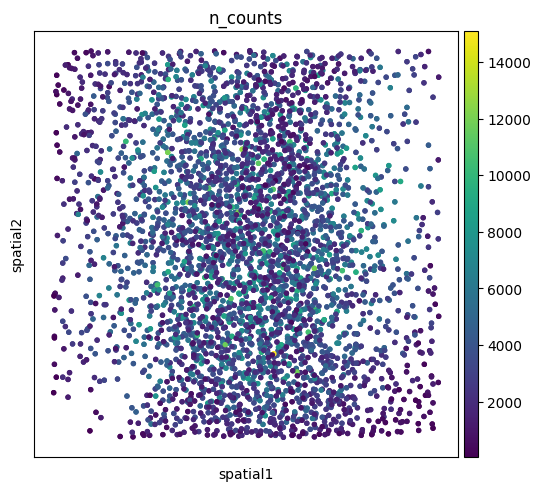

In [8]:
sq.pl.spatial_scatter(adata_sp, color="n_counts", shape=None)

In [9]:
from moscot.problems.space import MappingProblem

prob = MappingProblem(adata_sc=adata_sc, adata_sp=adata_sp_train)
prob = prob.prepare(
    sc_attr={"attr": "obsm", "key": "X_pca"},
    sp_attr={"attr": "obsm", "key": "X_pca_spatial"},
    # joint_attr=None,
    # callback="local-pca",
)

/home/icb/giovanni.palla/miniconda3/envs/moscot/lib/python3.9/site-packages/docrep/decorators.py:43: SyntaxWarning: 'batch_size' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


In [10]:
print(
    prob.problems[("src", "tgt")].xy.data.shape,
    prob.problems[("src", "tgt")].xy.data_y.shape,
)

(524, 900) (14249, 900)


In [43]:
params = {"epsilon": 1e-2, "alpha": 0.0001}

In [44]:
epsilon, alpha = params["epsilon"], params["alpha"]

In [74]:
prob = prob.solve(
    alpha=alpha, epsilon=epsilon, max_iterations=500, tau_a=1.0, tau_b=0.9
)
print(prob.solutions[list(prob.solutions.keys())[0]].converged)
print(prob.solutions[list(prob.solutions.keys())[0]].cost)

True
1896.4601725228156


In [75]:
adata_sp.var_names

Index(['1700022a21rik', '1700025g04rik', '4933401b06rik', '5830417i10rik',
       '9330102e08rik', '9430018g01rik', '9430083a17rik', 'Aanat', 'Aasdh',
       'Aatf',
       ...
       'Tyrp1', 'Ubqlnl', 'Ptgdr', 'P2ry4', 'Prdm6', 'Pde6b', 'Zp1', 'Dlx4',
       'Opn1sw', 'Pramef12'],
      dtype='object', length=10000)

In [76]:
true_df.shape

(524, 100)

In [69]:
# np.in1d(adata_sp_test.var_names, adata_sc.var_names)

In [77]:
adata_pred = prob.impute(var_names=true_df.columns.values, device="cpu")
pred_df = sc.get.obs_df(adata_pred, keys=true_df.columns.tolist())

/home/icb/giovanni.palla/code/moscot/moscot/problems/space/_mixins.py:352: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_pred = AnnData(np.nan_to_num(np.vstack(pred_list), nan=0.0, copy=False))


In [71]:
# true_df = sc.get.obs_df(adata_sp_test, keys=adata_sp_test.var_names.tolist())

In [78]:
pred_df.corrwith(true_df, method="pearson")

B3gntl1        NaN
B3galt2        NaN
Arl4d          NaN
Sipa1l2        NaN
Pamr1      0.02589
            ...   
Tnpo2          NaN
Lhx6           NaN
Acvr1b         NaN
Gpd1           NaN
Wdr13          NaN
Length: 100, dtype: float64

In [79]:
pred_df.corrwith(true_df, method="pearson").mean()

-0.007556094841950569

In [151]:
# from scipy.stats import pearsonr

# gene = "ICAM1"
# pearsonr(pred_df[gene].values, true_df[gene].values)

In [9]:
import tangram as tg
import torch

tg.pp_adatas(adata_sc, adata_sp_train, genes=adata_sp_train.var_names.tolist())

INFO:root:900 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:900 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


In [12]:
# device = torch.device("cuda:0")
device = torch.device("cpu")

In [11]:
del prob

NameError: name 'prob' is not defined

In [13]:
ad_map = tg.map_cells_to_space(adata_sc, adata_sp_train, device=device)
ad_ge = tg.project_genes(ad_map, adata_sc)

INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 900 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.675, KL reg: 0.018
Score: 0.783, KL reg: 0.000
Score: 0.787, KL reg: 0.000
Score: 0.787, KL reg: 0.000
Score: 0.787, KL reg: 0.000
Score: 0.788, KL reg: 0.000
Score: 0.788, KL reg: 0.000
Score: 0.788, KL reg: 0.000
Score: 0.788, KL reg: 0.000
Score: 0.788, KL reg: 0.000


INFO:root:Saving results..


In [17]:
ad_map.uns["training_history"]["kl_reg"][-1]

'0.00011053994967369363'

In [9]:
from scvi.external import GIMVI

GIMVI.setup_anndata(adata_sp_train, layer="counts")
GIMVI.setup_anndata(adata_sc, layer="counts")

Global seed set to 0
2022-08-10 19:02:27.589202: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.2/lib64:/usr/local/cuda/lib64:/usr/local/cuda-11.2/extras/CUPTI/lib64:/usr/local/cuda-11.2/lib64:/usr/local/cuda/lib64:/usr/local/cuda-11.2/extras/CUPTI/lib64
2022-08-10 19:02:27.589506: W external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)


In [10]:
model = GIMVI(adata_sc, adata_sp_train)

# train for 200 epochs
model.train(10, batch_size=256)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 10/10: 100%|██████████| 10/10 [01:42<00:00, 10.29s/it, loss=1.53e+03, v_num=1]


In [11]:
imputed = model.get_imputed_values(normalized=True, batch_size=256)

ValueError: expected 2D or 3D input (got 1D input)

In [42]:
import scvi

In [43]:
scvi.__version__

'0.16.4'

In [156]:
true_df.columns = [a.lower() for a in true_df.columns]

In [157]:
pred_df = sc.get.obs_df(ad_ge, keys=true_df.columns.tolist())

In [158]:
pred_df.corrwith(true_df, method="pearson")

slc6a7     0.334347
rasgrp2    0.125879
smarcd1    0.251178
stc2      -0.015233
cited2     0.285393
             ...   
impdh1     0.169322
pim3      -0.014086
sipa1l2    0.145808
tbc1d30    0.303578
adarb1     0.217383
Length: 100, dtype: float64

In [159]:
pred_df.corrwith(true_df, method="pearson").mean()

0.17790219399325075

In [26]:
adata_sc = ad.read(path_write / f"{dataset.lower()}_sc.h5ad")
adata_sp = ad.read(path_write / f"{dataset.lower()}_sp.h5ad")